In [1]:
#importing library
from scraper import scrape_kayak_flights # scraper
from database import write_df_to_mongoDB 
import pandas as pd # analysing and cleaning
from routes import routes #helper file containing routes
import re # regex
import matplotlib.pyplot as plt # data visualisation
import seaborn as sns # improve data visualisation
import warnings
warnings.filterwarnings('ignore')

# Data Extraction

In [2]:
routes[:5] # sample of routes

[['CAI', 'SVO', '2025-04-23', '2025-04-30'],
 ['CAI', 'LAX', '2025-04-23', '2025-04-30'],
 ['CAI', 'MNL', '2025-04-23', '2025-04-30'],
 ['CAI', 'SGN', '2025-04-23', '2025-04-30'],
 ['CAI', 'SZX', '2025-04-23', '2025-04-30']]

In [4]:
flights = [] # extracting data
print("--- Starting Kayak Flight Scraper ---")
for route in routes:
    flight = scrape_kayak_flights(*route)
    flights.append(flight)

--- Starting Kayak Flight Scraper ---
Navigating to: https://www.kayak.ae/flights/JFK-SVO/2025-04-23/2025-04-30?sort=price_a
Initializing WebDriver...
WebDriver initialized.
Waiting for flight results using CSS selector: 'div[class*='Fxw9-result-item-container']'...
Error: Timed out waiting for flight results to load.
Possible reasons: Incorrect selector, page structure changed, anti-scraping measures, or slow network.
Closing WebDriver.
Navigating to: https://www.kayak.ae/flights/JFK-BUD/2025-04-23/2025-04-30?sort=price_a
Initializing WebDriver...
WebDriver initialized.
Waiting for flight results using CSS selector: 'div[class*='Fxw9-result-item-container']'...
At least one result item appears to be present. Waiting for dynamic loading...
Found 17 potential flight results.

--- Processing Result 1 ---
  Price: AED 2,498
  Airlines: United Airlines
  Stops: 1 stop
  Duration: 13h 10m
  => Added: United Airlines - AED 2,498 - 1 stop - 13h 10m

--- Processing Result 2 ---
  Price: AED 2,

In [5]:
flattened = [item for sublist in flights for item in sublist] # preparing to save in cvs
df = pd.DataFrame(flattened)

In [7]:
df.head()

,origin,destination,price,airlines,stops,duration,search_url
0,JFK,BUD,"AED 2,498",United Airlines,1 stop,13h 10m,https://www.kayak.ae/flights/JFK-BUD/2025-04-2...
1,JFK,BUD,"AED 2,519",SWISS,1 stop,10h 30m,https://www.kayak.ae/flights/JFK-BUD/2025-04-2...
2,JFK,BUD,"AED 2,519",SWISS,1 stop,11h 35m,https://www.kayak.ae/flights/JFK-BUD/2025-04-2...
3,JFK,BUD,"AED 2,527",United Airlines,1 stop,13h 10m,https://www.kayak.ae/flights/JFK-BUD/2025-04-2...
4,JFK,BUD,N/A,N/A,N/A,N/A,https://www.kayak.ae/flights/JFK-BUD/2025-04-2...


In [8]:
df.to_csv("Data/flights.csv", index = False)

In [3]:
# combining different runs of data extraction
# df_flights_1 = pd.read_csv("Data/flights.csv")
# df_flights_2 = pd.read_csv("Data/flights_1.csv")
# df_flights_3 = pd.read_csv("Data/flights_2.csv")

# df_flights = pd.concat([df_flights_1, df_flights_2, df_flights_3])

# df_flights.to_csv("Data/AllFlights.csv", index = False)

# Data Cleaning, Processing, and Regular Expressions

In [3]:
df = pd.read_csv('Data/AllFlights.csv')

df.head()

,origin,destination,price,airlines,stops,duration,search_url
0,HBE,MLA,"AED 3,920",Turkish Airlines,1 stop,7h 05m,https://www.kayak.ae/flights/HBE-MLA/2025-04-2...
1,HBE,MLA,"AED 3,920",Turkish Airlines,1 stop,15h 30m,https://www.kayak.ae/flights/HBE-MLA/2025-04-2...
2,HBE,MLA,"AED 3,920",Turkish Airlines,1 stop,7h 05m,https://www.kayak.ae/flights/HBE-MLA/2025-04-2...
3,HBE,MLA,"AED 3,920",Turkish Airlines,1 stop,15h 30m,https://www.kayak.ae/flights/HBE-MLA/2025-04-2...
4,HBE,PRG,"AED 1,924",طيران الجزيرة‎,2 stops,22h 15m,https://www.kayak.ae/flights/HBE-PRG/2025-04-2...


In [3]:
df.shape

(1214, 7)

In [4]:
# droping search_url
df.drop(columns = 'search_url', inplace = True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1214 entries, 0 to 1213
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   origin       1214 non-null   object
 1   destination  1214 non-null   object
 2   price        735 non-null    object
 3   airlines     735 non-null    object
 4   stops        735 non-null    object
 5   duration     735 non-null    object
dtypes: object(6)
memory usage: 57.0+ KB


In [6]:
df.drop_duplicates(inplace = True) 

In [7]:
df.isna().sum() #cheaking for NAN values

origin          0
destination     0
price          80
airlines       80
stops          80
duration       80
dtype: int64

In [8]:
df.isnull().sum() # cheaking for nulls

origin          0
destination     0
price          80
airlines       80
stops          80
duration       80
dtype: int64

In [9]:
df.dropna(inplace = True)

In [10]:
df.shape

(280, 6)

In [11]:
# converting airlines to string
df['airlines'] = df['airlines'].astype(str)

In [12]:
# converting duration to minutes form
# extracting hour and minutes using regex

def convert_to_minutes(duration):
    match = re.search(r'(\d+)h\s+(\d+)m', duration) # separating hours and minutes
    if match:
        hours = int(match.group(1)) if match.group(1) else 0 
        minutes = int(match.group(2)) if match.group(2) else 0
        duration_in_minutes = hours * 60 + minutes # covering to minutes
        return duration_in_minutes
    return None

df['duration'] = df['duration'].apply(convert_to_minutes)

In [13]:
#converting price to USD
def convert_to_usd(price):
    only_price = price[4:].replace(',', '')
    price_in_usd = int(only_price) * 0.27 #converting the currency
    return price_in_usd

df['price'] = df['price'].apply(convert_to_usd)

In [14]:
#converting stops to int
def convert_to_int(stops):
    return 0 if stops == 'direct' else int(stops[0]) # if it direct it will return zero

df['stops'] = df['stops'].apply(convert_to_int)

In [15]:
df.head()

,origin,destination,price,airlines,stops,duration
0,HBE,MLA,1058.40,Turkish Airlines,1,425
1,HBE,MLA,1058.40,Turkish Airlines,1,930
4,HBE,PRG,519.48,طيران الجزيرة‎,2,1335
5,HBE,PRG,545.67,طيران الجزيرة‎,2,1335
6,HBE,PRG,611.82,Air Arabia,2,1375


In [ ]:
#saving the result
df.to_csv("Data/data.csv", index = False)

# Data Analysis

In [16]:
df.describe()

,price,stops,duration
count,280.000000,280.000000,280.000000
mean,1096.898143,1.196429,1207.900000
std,559.552611,0.656362,698.913646
min,129.060000,0.000000,75.000000
25%,687.757500,1.000000,672.500000
50%,1066.365000,1.000000,1105.000000
75%,1431.675000,2.000000,1601.250000
max,2952.450000,3.000000,3105.000000


In [54]:
df["destination"].unique()

array(['MLA', 'PRG', 'DOH', 'HEL', 'BKK', 'HNL', 'BOM', 'CPH', 'ICN',
       'CPT', 'PAR', 'IST', 'OSL', 'BNE', 'BER', 'TYO', 'DXB', 'LOS',
       'STO', 'DUB', 'MEL', 'MEX', 'ZRH', 'SYD', 'KUL', 'ORD', 'SFO',
       'HKG', 'WAW', 'LIS', 'ATH', 'SIN', 'MAD', 'DEL', 'SCL', 'LON',
       'JNB', 'GRU', 'BRU', 'TUN', 'JED', 'LAX', 'SGN', 'TPE', 'YVR',
       'LIM', 'BOG', 'UIO', 'KTM', 'LAD', 'NBO', 'ABV', 'DAR', 'ACC',
       'TBS', 'BAH', 'MCT', 'BEY', 'BUD', 'HND', 'MNL', 'AKL', 'EZE',
       'KIX', 'HAN', 'PER', 'RUH', 'GIG', 'EVN', 'BGW'], dtype=object)

In [18]:
df['airlines'].unique()

array(['Turkish Airlines', 'طيران الجزيرة\u200e', 'Air Arabia',
       'flydubai', 'SAUDIA', 'Wizz Air', 'ITA Airways', 'Delta',
       'Air France', 'China Eastern', 'Emirates', 'Ethiopian Air',
       'Iberia', 'Qatar Airways', 'Oman Air', 'Egyptair', 'Ajet',
       'flynas', 'MEA', 'United Airlines', 'SWISS', 'ANA',
       'Cathay Pacific', 'AIR PREMIA', 'Batik Air', 'Indonesia AirAsia',
       'Avianca', 'Vietnam Airlines', 'Pegasus Airlines',
       'Virgin Atlantic', 'KLM', 'Royal Air Maroc', 'Aegean Airlines'],
      dtype=object)

In [55]:
len(df["destination"].unique())

70

In [56]:
len(df['airlines'].unique())

33

<h2>Price</h2>
<ul>
    <li>Mean: 1,096.90</li>
    <li>Range: 129.06 – 2,952.45</li>
</ul>
<h2>Stops</h2>
<ul>
    <li>Most flights have 1 or 2 stops</li>
</ul>
<h2>Destinations</h2>
<ul>
    <li>70 unique destinations</li>
</ul>
<h2>Airlines</h2>
<ul>
    <li>33 unique airlines</li>
</ul>

# Data Visualization

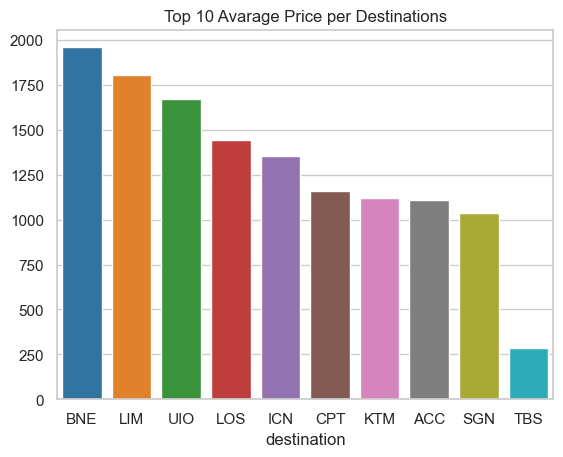

In [48]:
top_destinations = df["destination"].value_counts().head(10).index
top_avg_price_per_dest = df[df["destination"].isin(top_destinations)].groupby("destination")['price'].mean().sort_values(ascending = False)

sns.barplot(x = top_avg_price_per_dest.index,
            hue = top_avg_price_per_dest.index, 
            y = top_avg_price_per_dest.values, palette= "tab10", legend = False)
plt.title("Top 10 Avarage Price per Destinations")
plt.show()

### Some destinations (like SGN and TBS) have relatively lower average prices compared to others.

### Prices vary significantly by location, likely due to distance or airline competition.

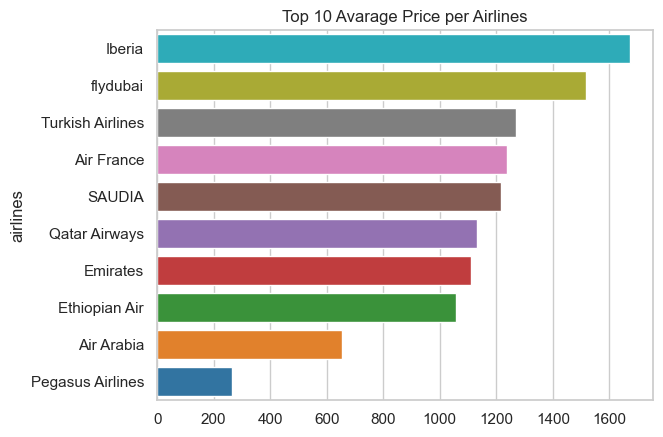

In [50]:
top_destinations = df["airlines"].value_counts().head(10).index
top_avg_price_per_dest = df[df["airlines"].isin(top_destinations)].groupby("airlines")['price'].mean().sort_values(ascending = False)

sns.barplot(x = top_avg_price_per_dest.values, hue = top_avg_price_per_dest.values, 
            y = top_avg_price_per_dest.index, palette= "tab10", legend = False)

plt.title("Top 10 Avarage Price per Airlines")
plt.show()

### Airlines like lberia and flydubai show higher average ticket prices.

### Budget carriers like Pegasus and Air Arabia offer lower average prices.

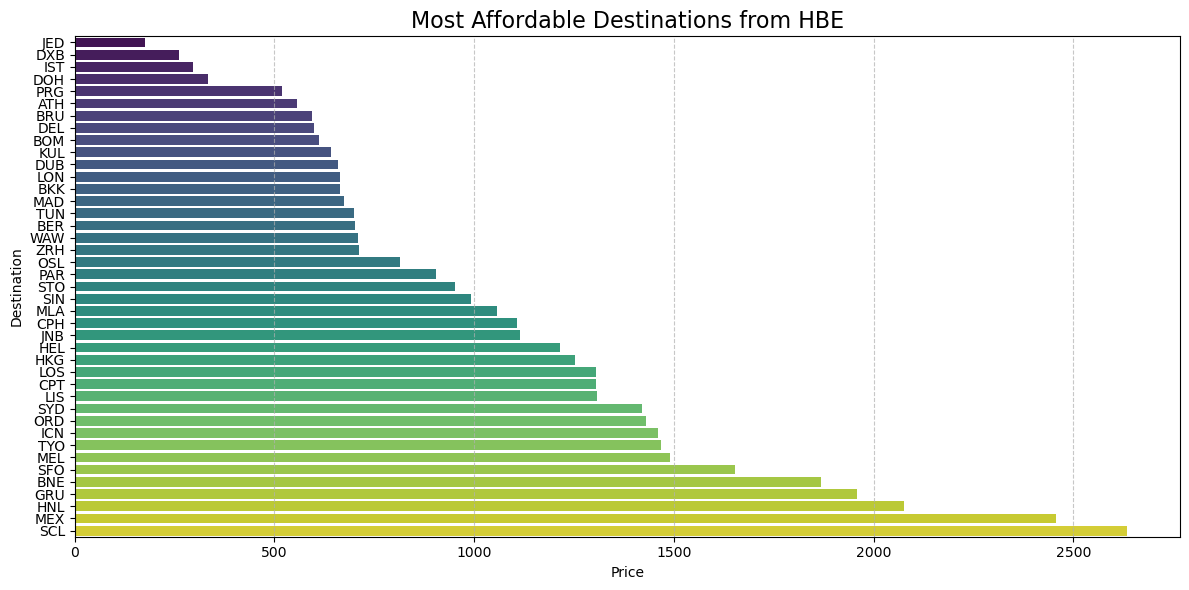

In [2]:
cheapest_destinations = df.groupby(['origin', 'destination'])['price'].min().reset_index()

origin_city = 'HBE'
cheapest_from_origin = cheapest_destinations[cheapest_destinations['origin'] == origin_city]

cheapest_from_origin = cheapest_from_origin.sort_values('price', ascending=True)

plt.figure(figsize=(12, 6))
sns.barplot(
    x='price',
    y='destination',
    data=cheapest_from_origin,
    palette='viridis'
)
plt.title(f'Most Affordable Destinations from {origin_city}', fontsize=16)
plt.xlabel('Price')
plt.ylabel('Destination')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### The visualization above shows — destinations like Jeddah, Dubai, and Istanbul are the most 
### affordable from HBE(Borg El Arab)

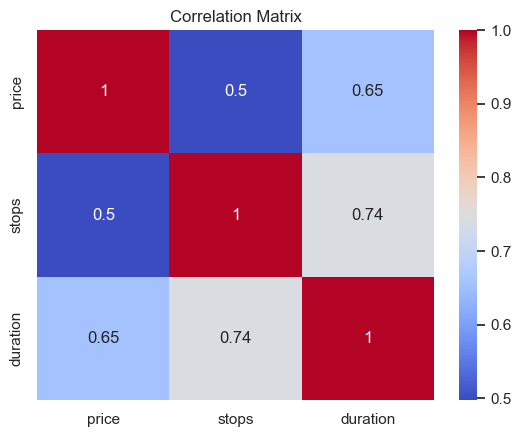

In [25]:
correlation_matrix = df[["price", "stops", "duration"]].corr()

sns.heatmap(correlation_matrix, annot = True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

### The heatmap reveals a strong correlation between duration and the number of stops, as well as a significant correlation between price and duration.

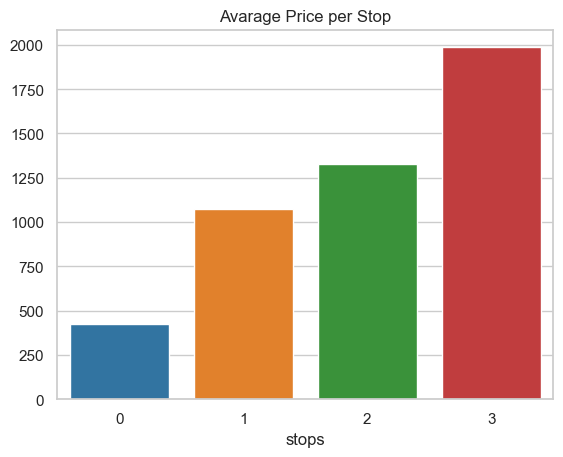

In [67]:
avg_price_per_stop = df[["stops", "price"]].groupby("stops")['price'].mean()

sns.barplot(x = avg_price_per_stop.index , 
            hue = avg_price_per_stop.index , 
            y = avg_price_per_stop.values , 
            palette= "tab10", legend = False)

plt.title("Avarage Price per Stop")
plt.show()

### increasing the number of stops will increase the price

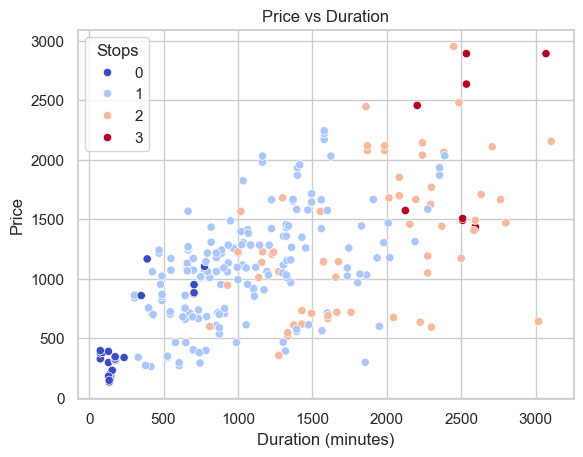

In [69]:
sns.scatterplot(data=df, x='duration', y='price', hue='stops', palette='coolwarm')
plt.title('Price vs Duration')
plt.xlabel('Duration (minutes)')
plt.ylabel('Price')
plt.legend(title='Stops')
plt.show()

# Data Storage

In [2]:
df = pd.read_csv("data.csv")
write_df_to_mongoDB(df,mongodb_port = 27017)

Number of document inserted: 280
Done


# Streamlit

In [3]:
!streamlit run web_app.py

^C
